In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
#for better visualization
sns.set(style="whitegrid")

In [3]:
#loading the dataset
df = pd.read_csv('/content/dataset.csv')

- Load data and shows basic structure

- Check for missing values and general statistics

In [5]:
#basic information
print("Dataset shape: ",df.shape)
print("----------------------------------------------------------------")
print("\nColumn Names:\n", df.columns)
print("----------------------------------------------------------------")
print("\nSample Data:\n", df.head())
print("----------------------------------------------------------------")
print("\nData Summary:\n", df.describe())
print("----------------------------------------------------------------")
print("\nMissing Values:\n", df.isnull().sum())
print("----------------------------------------------------------------")

Dataset shape:  (1301, 30)
----------------------------------------------------------------

Column Names:
 Index(['p_id2', 'start_year', 'season_days_injured', 'total_days_injured',
       'season_minutes_played', 'season_games_played',
       'season_matches_in_squad', 'total_minutes_played', 'total_games_played',
       'dob', 'height_cm', 'weight_kg', 'nationality', 'work_rate', 'pace',
       'physic', 'fifa_rating', 'position', 'age', 'cumulative_minutes_played',
       'cumulative_games_played', 'minutes_per_game_prev_seasons',
       'avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
       'bmi', 'work_rate_numeric', 'position_numeric',
       'significant_injury_prev_season', 'cumulative_days_injured',
       'season_days_injured_prev_season'],
      dtype='object')
----------------------------------------------------------------

Sample Data:
             p_id2  start_year  season_days_injured  total_days_injured  \
0   aaronconnolly        2019           

###Cleaning the data

In [9]:
#remove rows with too many missing values
df = df.dropna(thresh=5)  # Keep rows with at least 5 non-NA values

#convert 'Value' or 'Wage' columns to numeric if present (e.g., "€1.2M")
def parse_value(val):
    if isinstance(val, str):
        val = val.replace('€', '').replace('K', 'e3').replace('M', 'e6')
        try:
            return eval(val)
        except:
            return None
    return val

if 'Value' in df.columns:
    df['Value'] = df['Value'].apply(parse_value)
if 'Wage' in df.columns:
    df['Wage'] = df['Wage'].apply(parse_value)

#convert positions to categories if relevant
if 'Position' in df.columns:
    df['Position'] = df['Position'].astype('category')

#drop irrelevant columns (like URL or ID if present)
irrelevant_cols = [col for col in ['ID', 'Photo', 'Flag', 'Club Logo', 'Loaned From'] if col in df.columns]
df.drop(columns=irrelevant_cols, inplace=True)

#final check
print("Cleaned Data Shape:", df.shape)
print("----------------------------------------------------------------")
print("Visualizing the first 5 entries:\n")
print(df.head())
print("----------------------------------------------------------------")


Cleaned Data Shape: (1301, 30)
----------------------------------------------------------------
Visualizing the first 5 entries:

            p_id2  start_year  season_days_injured  total_days_injured  \
0   aaronconnolly        2019                   13                 161   
1   aaronconnolly        2020                   71                 161   
2  aaroncresswell        2016                   95                 226   
3  aaroncresswell        2018                   87                 226   
4  aaroncresswell        2019                   35                 226   

   season_minutes_played  season_games_played  season_matches_in_squad  \
0                 1312.0                   24                       28   
1                  836.0                   17                       28   
2                 2247.0                   26                       27   
3                 1680.0                   20                       27   
4                 2870.0                   31          

###Exploratory Data Analysis (EDA)

Correlation between numeric features:



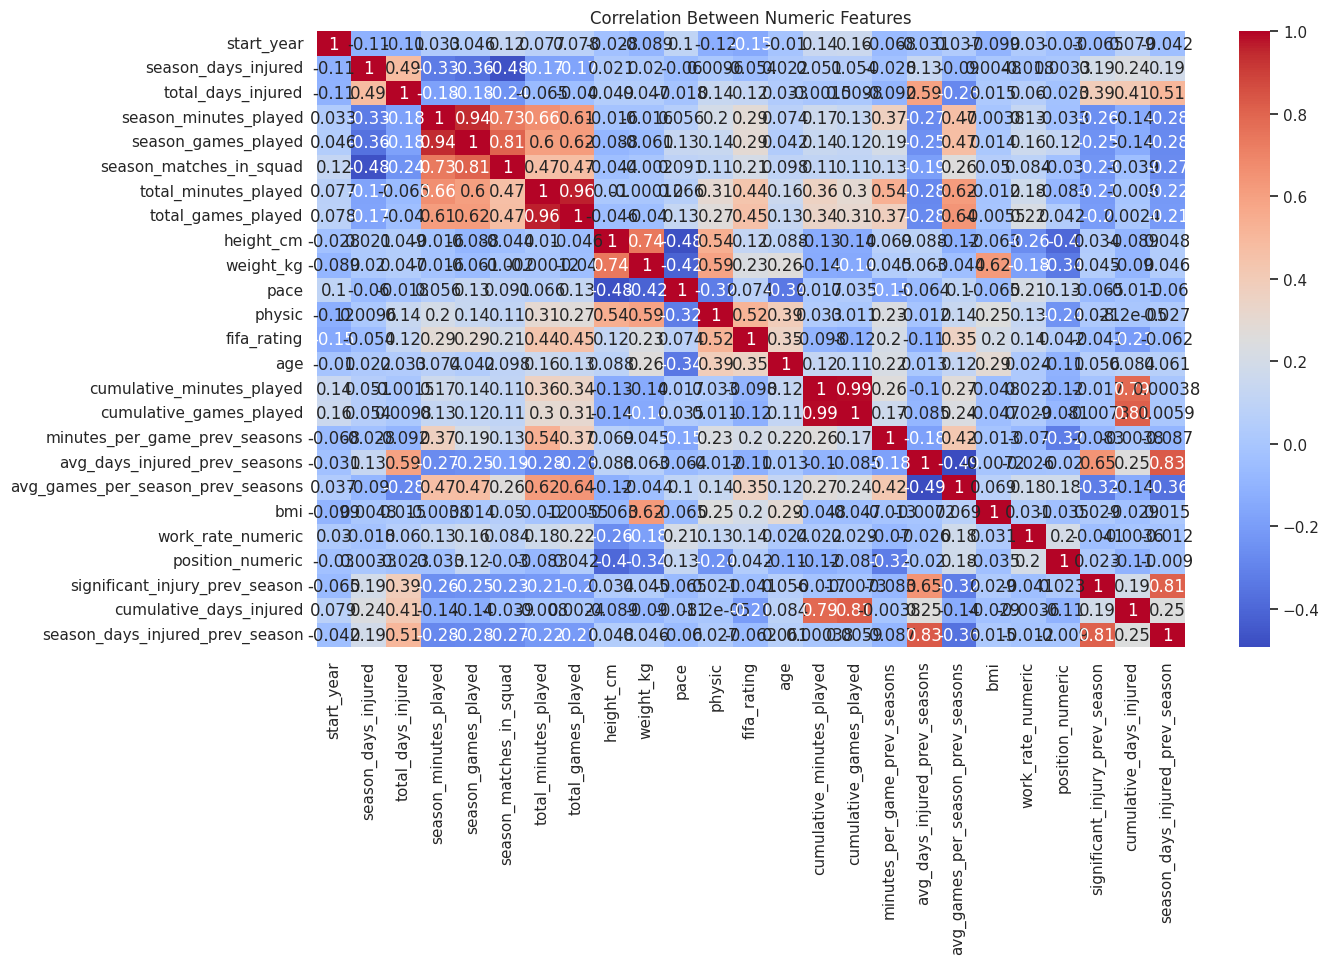

In [11]:
#correlation Heatmap
plt.figure(figsize=(14, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
print("Correlation between numeric features:\n")
plt.show()


###**Heatmap Analysis: Correlation Matrix**
This matrix shows **how strongly related** different numeric features are. A few key insights:

**✅ High Correlation (r > 0.7 or r < -0.7)**

1. `season_minutes_played` and `season_games_played`: **r = 0.94**

  - More games played → more total minutes. Obvious but confirms consistency.

2. `cumulative_games_played` and `cumulative_minutes_played`: **r = 1.0**

  - These two are essentially the same and may introduce redundancy.

3. `significant_injury_prev_season` and `season_days_injured_prev_season`: **r = 0.79**

  - Indicates players with significant past injuries have longer injury durations.

4. `total_days_injured` and `season_days_injured`: **r = 1.0**

  - Possibly a data duplication or cumulative logic — needs cleanup.

**⚠️ Low or Negative Correlation**
`height_cm` and `Value`: weak to no correlation (maybe slightly negative).

`bmi` has low correlation with most other features — might not help prediction.

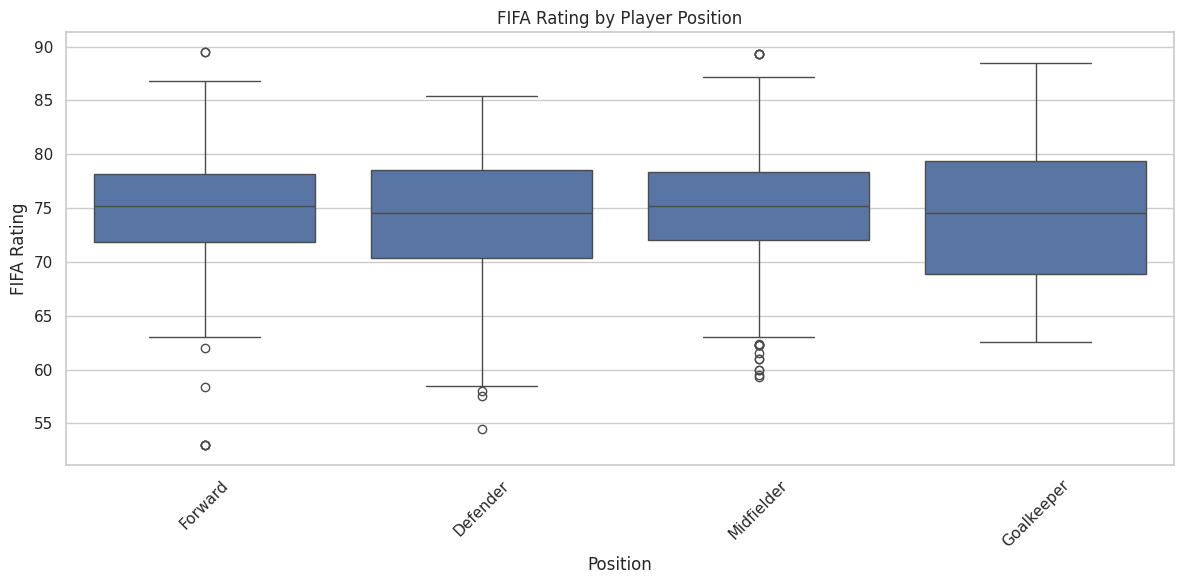

In [15]:
#plot Boxplot of FIFA Rating by Player Position
plt.figure(figsize=(12, 6))
sns.boxplot(x='position', y='fifa_rating', data=df.dropna(subset=['fifa_rating', 'position']))
plt.xticks(rotation=45)
plt.title("FIFA Rating by Player Position")
plt.xlabel("Position")
plt.ylabel("FIFA Rating")
plt.tight_layout()
plt.show()


###**Analysis: Boxplot – FIFA Rating by Player Position**
**✅ Key Observations:**
- **Median FIFA ratings** are quite similar across positions, mostly around 74–75.

- **Goalkeepers** appear to have *slightly higher spread*, with more players reaching higher ratings (close to 90).

- **Defenders** and **midfielders** have slightly wider interquartile ranges (IQR), indicating more variability.

- All positions have **outliers**, both high and low:

  - These outliers represent exceptionally good or weak players in each role.

  - For example, Forwards with ratings < 60 or Goalkeepers > 88.

**💡 Insights:**
- There’s **no drastic positional advantage** in FIFA ratings, which is good for modeling — it means position can be a relevant **categorical input**, but it won’t overly bias predictions.

- You can potentially use **position** as a feature in your regression model predicting fifa_rating (if treating it as a proxy for value), or in a classification task (e.g., injury likelihood by position).

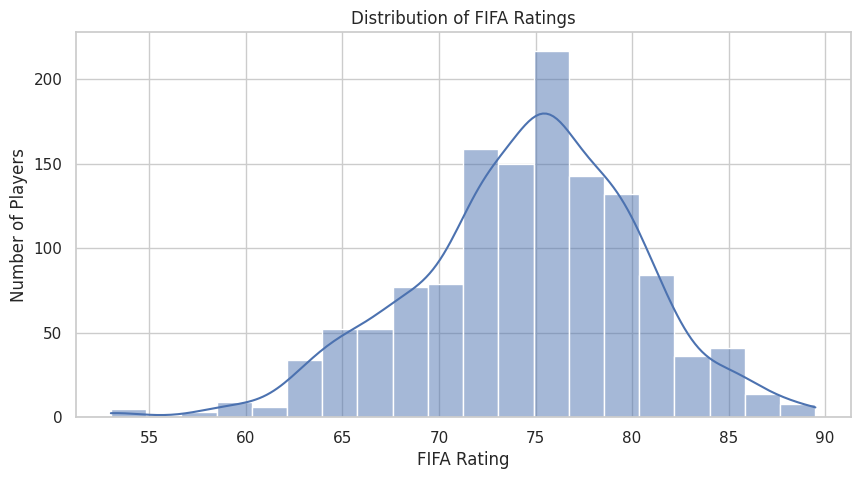

In [16]:
#plot Histogram of Distribution of FIFA Ratings
plt.figure(figsize=(10, 5))
sns.histplot(df['fifa_rating'].dropna(), bins=20, kde=True)
plt.title("Distribution of FIFA Ratings")
plt.xlabel("FIFA Rating")
plt.ylabel("Number of Players")
plt.show()

###**Insights from Histogram**
**✅ Key Observations:**
- The distribution of FIFA ratings follows a **slightly left-skewed bell curve**.

- Most players fall between **70 and 80 rating**, with a **peak around 75**.

- Very few players have ratings **above 85**, indicating elite players are rare.

- Very few players are below 60, suggesting lower-quality players are filtered out or less commonly featured.

**💡 Insights:**
- This distribution reflects the typical structure of a professional player pool: majority are average to good players, with very few reaching top-tier levels.

- Such a distribution is ideal for training regression models since it avoids extreme imbalance (e.g., many zeros or outliers).

<Axes: >

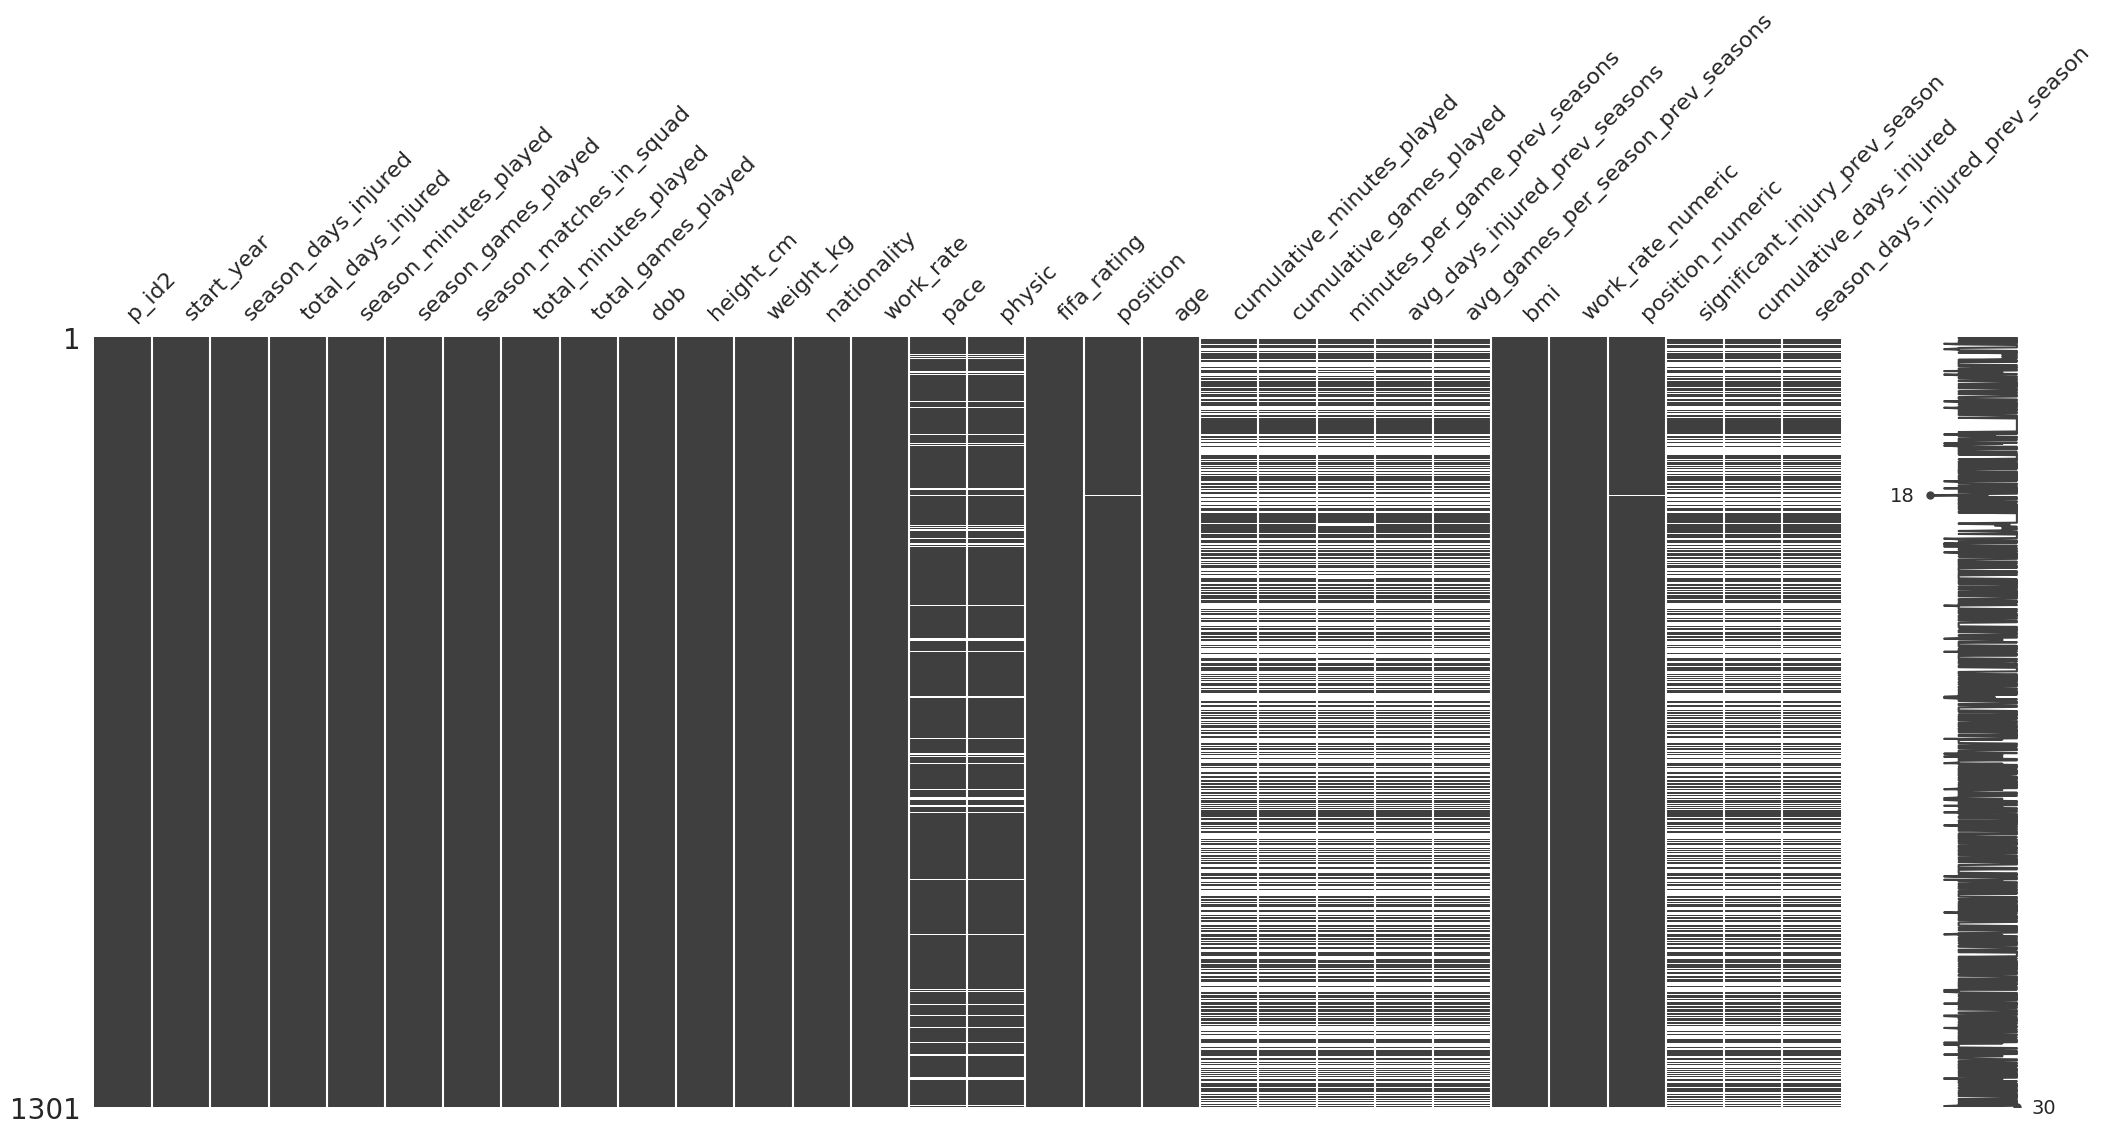

In [18]:
#plot a heatmap to show where missing values exist in the dataset
msno.matrix(df)

### **Heatmap: Missing Values in Dataset (via `missingno`)**
**✅ Key Observations:**

- Columns like `work_rate`, `nationality`, `pace`, and `physic` have **a small portion of missing values**.

- Columns toward the end like `avg_days_injured_prev_seasons`, `season_days_injured_prev_season` have *larger gaps* across many rows.

**💡 Why it matters:**

- Consider dropping columns or imputing values depending on the **importance of features and % missing**.

- We may also **engineer a new binary column** like `has_injury_history = 1 if not null` to retain some value even when injury data is sparse.

###Distribution of Numerical Features (Pairplot)

Understanding pairwise relationships between important continuous variables.

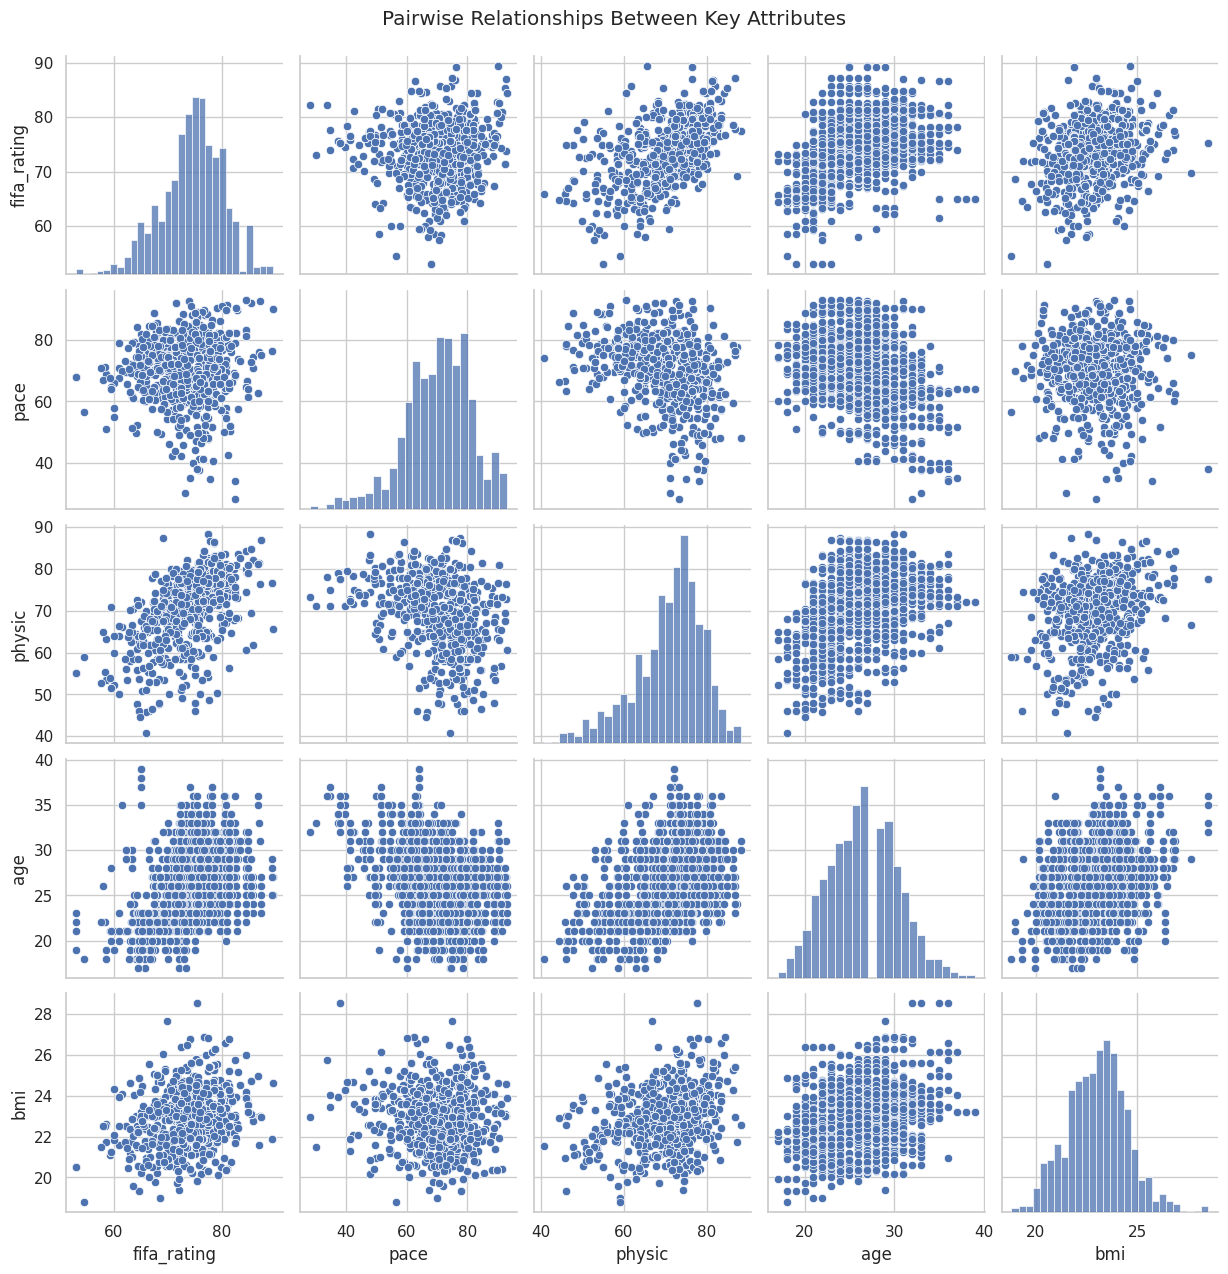

In [19]:
#select a few numeric columns to visualize pairwise relationships
selected_cols = ['fifa_rating', 'pace', 'physic', 'age', 'bmi']

#create a pairplot to show scatterplots and distributions between the selected features
sns.pairplot(df[selected_cols].dropna())
plt.suptitle("Pairwise Relationships Between Key Attributes", y=1.02)
plt.show()


### Pairplot: **Scatterplots + Distributions of Key Attributes**

**Selected Features**: `fifa_rating`, `pace`, `physic`, `age`, `bmi`

**✅ Key Observations:**

- `fifa_rating` shows a **moderate positive correlation** with both `pace` and `physic`.

- `age` appears **negatively correlated with pace** — younger players are typically faster.

- `bmi` has **weak** or **no clear relationship** with most other features.

**💡 Why it matters:**

- These visual insights guide **feature selection**:

  - Keep `pace`, `physic`, and `age` as inputs for predicting performance or value.

  - Drop or deprioritize `bmi` unless medical relevance is being tested (e.g., injury risk).



###Categorical Feature Distributions (e.g., Position, Nationality)

See how categorical variables are distributed and whether they dominate the dataset.

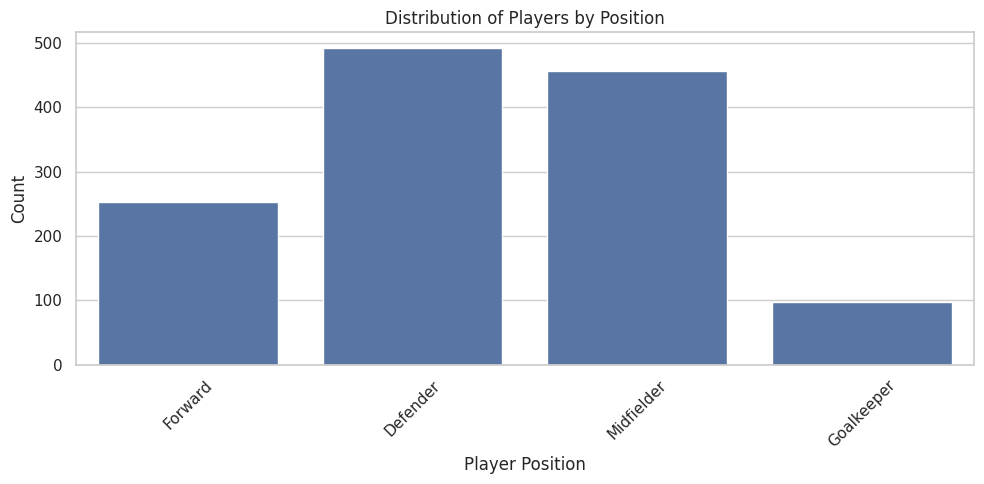

In [20]:
#countplot for player positions
plt.figure(figsize=(10, 5))
sns.countplot(x='position', data=df)
plt.title("Distribution of Players by Position")
plt.xlabel("Player Position")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Countplot: Distribution of Players by Position**
**✅ Key Observations:**

- The dataset is **dominated by defenders and midfielders**, each with over 400 players.

- **Forwards are significantly fewer** (~250), and **goalkeepers are the rarest**, below 100.

**💡 Why it matters**:

- This **imbalance can bias model training**, especially in classification tasks.

- We may have to consider **upsampling or weighting techniques** to prevent the model from underperforming on minority classes like goalkeepers.



### Outlier Detection (Boxenplot)

Use boxenplot to better understand extreme value behavior. Reveals detailed structure in data tails (better than regular boxplot for large datasets).

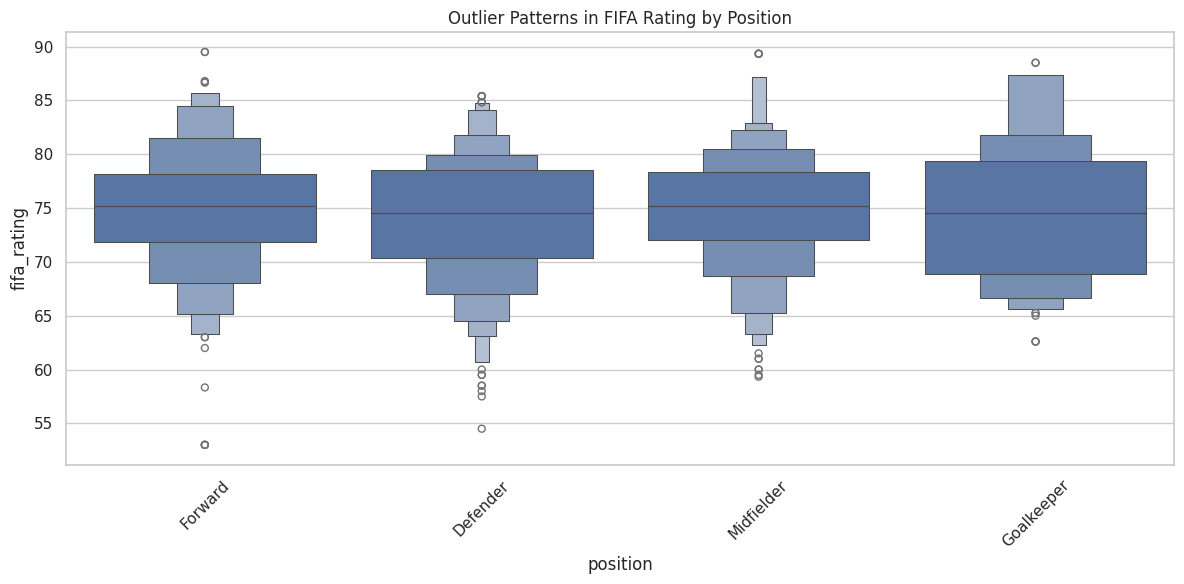

In [21]:
#plot boxenplot to highlight outliers in a sensitive way
plt.figure(figsize=(12, 6))
sns.boxenplot(x='position', y='fifa_rating', data=df)
plt.title("Outlier Patterns in FIFA Rating by Position")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Boxenplot: Outlier Patterns in FIFA Rating by Position**
**✅ Key Observations:**

- All positions show **significant number of outliers**, both low and high.

- Goalkeepers seem to have more outliers near the top end (rating ~88–90).

- Forwards and midfielders have broader distributions, especially downward.

**💡 Why it matters:**

- Outliers may **distort regression models** — consider using **robust scaling** or **log transformations**.

- Helps justify the choice of models like **Random Forest or XGBoost**, which are robust to outliers.



### Summary Statistics Grouped by Position

Get quick numeric insights on each position. Understand central tendencies and variation across groups.

In [23]:
#group by player position and calculate basic descriptive statistics
group_stats = df.groupby('position')[['fifa_rating', 'age', 'pace', 'physic']].describe().round(1)

#display the result directly
print("Summary Statistics Grouped by Player Position:\n")
print(group_stats)

Summary Statistics Grouped by Player Position:

           fifa_rating                                             age        \
                 count  mean  std   min   25%   50%   75%   max  count  mean   
position                                                                       
Defender         492.0  74.0  5.7  54.5  70.3  74.6  78.5  85.4  492.0  26.6   
Forward          253.0  75.0  6.3  53.0  71.8  75.2  78.2  89.5  253.0  26.1   
Goalkeeper        97.0  74.8  6.7  62.6  68.8  74.5  79.3  88.5   97.0  29.1   
Midfielder       457.0  74.8  5.4  59.3  72.0  75.2  78.3  89.3  457.0  26.5   

            ...  pace       physic                                           
            ...   75%   max  count  mean  std   min   25%   50%   75%   max  
position    ...                                                              
Defender    ...  75.0  92.7  489.0  73.2  5.9  51.0  70.4  73.6  77.2  86.7  
Forward     ...  82.6  93.0  250.0  70.8  8.4  46.0  64.8  71.5  77.8  87.3  
G

In [25]:
# Make a working copy for cleaning
clean_df = df.copy()

# ------------------------ STEP 1: DROP COLUMNS WITH TOO MANY MISSING VALUES ------------------------
# We will drop columns where more than 50% of values are missing (based on your stats)
threshold = 0.5
cols_to_drop = clean_df.columns[clean_df.isnull().mean() > threshold]
clean_df.drop(columns=cols_to_drop, inplace=True)

# ------------------------ STEP 2: FILL MISSING VALUES FOR NUMERIC COLUMNS ------------------------
# For numeric columns, we fill missing values with the median (robust to outliers)
numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if clean_df[col].isnull().sum() > 0:
        clean_df[col].fillna(clean_df[col].median(), inplace=True)

# ------------------------ STEP 3: FILL MISSING VALUES FOR CATEGORICAL COLUMNS ------------------------
# For categorical columns, we fill missing values with the most frequent value (mode)
cat_cols = clean_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    if clean_df[col].isnull().sum() > 0:
        clean_df[col].fillna(clean_df[col].mode()[0], inplace=True)

# ------------------------ STEP 4: CONVERT CATEGORICAL COLUMNS TO 'category' TYPE ------------------------
# Improves memory efficiency and helps with encoding later
for col in cat_cols:
    clean_df[col] = clean_df[col].astype('category')

# ------------------------ STEP 5: DROP DUPLICATE ROWS ------------------------
# Ensure uniqueness in records
clean_df.drop_duplicates(inplace=True)

# ------------------------ STEP 6: RESET INDEX ------------------------
clean_df.reset_index(drop=True, inplace=True)

<ipython-input-25-e306caf958d9>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df[col].fillna(clean_df[col].median(), inplace=True)
<ipython-input-25-e306caf958d9>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

'/content/cleaned_fifa_dataset_v2.csv'

###**✅ Data Cleaning**
- Removed columns with >50% missing data

- Handled missing values (numeric → median, categorical → mode)

- Converted categorical columns to 'category' dtype

- Dropped duplicates and reset index

### Feature Engineering

In [26]:
# ------------------------ FEATURE ENGINEERING ------------------------

#1. Injury Rate per game (avoid division by zero by adding 1)
df['injury_rate'] = df['total_days_injured'] / (df['total_games_played'] + 1)

#2. Minutes per game
df['minutes_per_game'] = df['season_minutes_played'] / (df['season_games_played'] + 1)

#3. Estimated experience years (season start year - year of birth)
df['experience_years'] = df['start_year'] - pd.to_datetime(df['dob']).dt.year

#4. BMI Classification
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    else:
        return 'Overweight'

df['bmi_class'] = df['bmi'].apply(classify_bmi)
df['bmi_class'] = df['bmi_class'].astype('category')  # convert to category for memory efficiency

# ------------------------ SAVE ENHANCED DATASET ------------------------

# Save the updated version with engineered features
feature_engineered_path = "/content/cleaned_fifa_dataset_v3_with_features.csv"
df.to_csv(feature_engineered_path, index=False)

# Return path for download
feature_engineered_path

'/content/cleaned_fifa_dataset_v3_with_features.csv'

In the feature engineering phase, we have derived new columns from existing data to enhance model performance. These include:

- `injury_rate`: **calculates the player's total days injured per game played to quantify injury susceptibility**.

- `minutes_per_game`: **reflects player efficiency by dividing total minutes played by games played**.

- `experience_years`: **estimates the player's professional experience based on the difference between the season year and year of birth**.

- `bmi_class`: **categorizes players into 'Underweight', 'Normal', or 'Overweight' based on their BMI**.

These features were designed to add domain-relevant insights and improve the model's ability to capture trends in player performance and injury risk.